In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install optuna > /dev/null

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [ ]:
tf.random.set_seed(47)
np.random.seed(47)

In [ ]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [ ]:
plt.rcParams['figure.figsize'] = (16,6)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AAPL.csv to AAPL.csv


In [ ]:
df = pd.read_csv('AAPL.csv')
df['Date'] = pd.to_datetime(df.Date)

In [ ]:
# Include only the desired columns (Open, Close, Low, High, Adj Close) and drop 'Volume'
df = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']]

# Optionally, you can rename the columns for consistency
df.columns = ['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']

# Display the first few rows of the updated DataFrame
print(df.head())

        Date      Open     Close       Low      High  Adj Close
0 2010-01-04  7.622500  7.643214  7.585000  7.660714   6.461975
1 2010-01-05  7.664286  7.656429  7.616071  7.699643   6.473148
2 2010-01-06  7.656429  7.534643  7.526786  7.686786   6.370185
3 2010-01-07  7.562500  7.520714  7.466071  7.571429   6.358407
4 2010-01-08  7.510714  7.570714  7.466429  7.571429   6.400681


In [ ]:
df.describe()

,Date,Open,Close,Low,High,Adj Close
count,2640,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000
mean,2015-04-01 01:20:43.636363776,29.814686,29.832355,29.532203,30.106765,27.541944
min,2010-01-04 00:00:00,6.870357,6.858929,6.794643,7.000000,5.798901
25%,2012-08-14 18:00:00,16.594553,16.601607,16.450982,16.766965,14.306166
50%,2015-04-01 12:00:00,25.712499,25.750000,25.576250,26.057500,23.327105
75%,2017-11-10 18:00:00,39.950625,39.963127,39.615626,40.244375,37.592599
max,2020-06-29 00:00:00,91.250000,91.632500,90.567497,93.095001,89.489677
std,NaN,17.080073,17.125851,16.917317,17.295182,17.132834


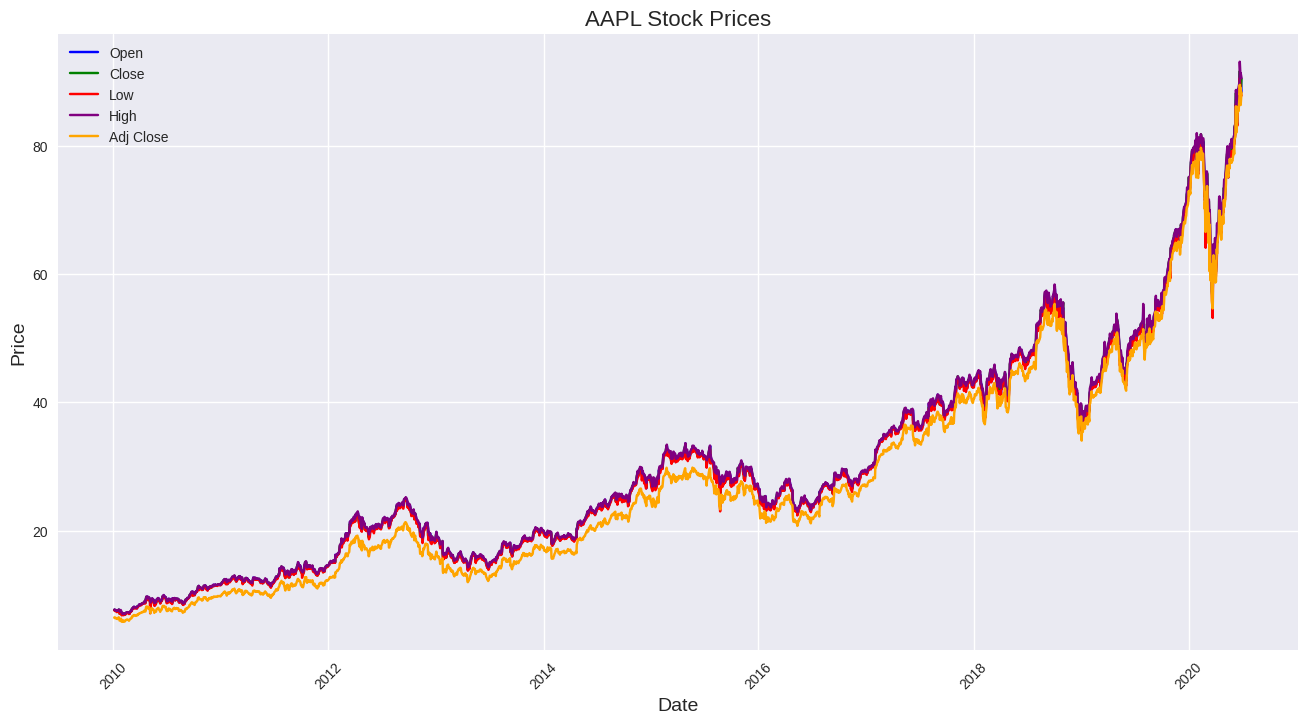

In [ ]:
plt.figure(figsize=(16, 8))  # Set the figure size

plt.title('AAPL Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Plot all price columns
plt.plot(df['Date'], df['Open'], label='Open', color='blue')
plt.plot(df['Date'], df['Close'], label='Close', color='green')
plt.plot(df['Date'], df['Low'], label='Low', color='red')
plt.plot(df['Date'], df['High'], label='High', color='purple')
plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='orange')

plt.legend()  # Show legend
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Show grid
plt.show()

In [ ]:
# Calculate the average price for each day
df['avg_price'] = df[['Open', 'Close', 'Low', 'High', 'Adj Close']].mean(axis=1)

# Calculate percentage change based on the average price
df['returns'] = df['avg_price'].pct_change() * 100

# Drop any rows with missing values generated by pct_change()
df.dropna(inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Display the DataFrame to verify the changes
print(df.head())

        Date      Open     Close       Low      High  Adj Close  avg_price  \
0 2010-01-05  7.664286  7.656429  7.616071  7.699643   6.473148   7.421915   
1 2010-01-06  7.656429  7.534643  7.526786  7.686786   6.370185   7.354966   
2 2010-01-07  7.562500  7.520714  7.466071  7.571429   6.358407   7.295824   
3 2010-01-08  7.510714  7.570714  7.466429  7.571429   6.400681   7.303993   
4 2010-01-11  7.600000  7.503929  7.444643  7.607143   6.344214   7.299986   

    returns  
0  0.368303  
1 -0.902053  
2 -0.804104  
3  0.111971  
4 -0.054869  


In [ ]:
# Create a new DataFrame 'data' with all price features and returns
data = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close', 'returns']]

# Display the first few rows of the new DataFrame
print(data.head())

        Date      Open     Close       Low      High  Adj Close   returns
0 2010-01-05  7.664286  7.656429  7.616071  7.699643   6.473148  0.368303
1 2010-01-06  7.656429  7.534643  7.526786  7.686786   6.370185 -0.902053
2 2010-01-07  7.562500  7.520714  7.466071  7.571429   6.358407 -0.804104
3 2010-01-08  7.510714  7.570714  7.466429  7.571429   6.400681  0.111971
4 2010-01-11  7.600000  7.503929  7.444643  7.607143   6.344214 -0.054869


In [ ]:
# Convert the 'data' DataFrame to a NumPy array
data_array = data.values

# Display the shape of the array
print("Shape of the NumPy array:", data_array.shape)

# Optionally, display the array
print(data_array)

Shape of the NumPy array: (2639, 7)
[[Timestamp('2010-01-05 00:00:00') 7.664286 7.656429 ... 7.699643
  6.473148 0.3683025876736412]
 [Timestamp('2010-01-06 00:00:00') 7.656429 7.534643 ... 7.686786
  6.370185 -0.9020528582150189]
 [Timestamp('2010-01-07 00:00:00') 7.5625 7.520714 ... 7.571429 6.358407
  -0.8041043508319135]
 ...
 [Timestamp('2020-06-25 00:00:00') 90.175003 91.209999 ... 91.25
  89.077057 0.022626037805451027]
 [Timestamp('2020-06-26 00:00:00') 91.102501 88.407501 ... 91.330002
  86.340118 -1.2567911056878045]
 [Timestamp('2020-06-29 00:00:00') 88.3125 90.445 ... 90.542503 88.329948
  0.003329777866034611]]


In [ ]:
# Drop the 'Date' column from the DataFrame
data = data.drop('Date', axis=1).values

# Display the shape of the array
print("Shape of the NumPy array:", data.shape)

# Optionally, display the array
print(data)

Shape of the NumPy array: (2639, 6)
[[ 7.66428600e+00  7.65642900e+00  7.61607100e+00  7.69964300e+00
   6.47314800e+00  3.68302588e-01]
 [ 7.65642900e+00  7.53464300e+00  7.52678600e+00  7.68678600e+00
   6.37018500e+00 -9.02052858e-01]
 [ 7.56250000e+00  7.52071400e+00  7.46607100e+00  7.57142900e+00
   6.35840700e+00 -8.04104351e-01]
 ...
 [ 9.01750030e+01  9.12099990e+01  8.93925020e+01  9.12500000e+01
   8.90770570e+01  2.26260378e-02]
 [ 9.11025010e+01  8.84075010e+01  8.82549970e+01  9.13300020e+01
   8.63401180e+01 -1.25679111e+00]
 [ 8.83125000e+01  9.04450000e+01  8.78200000e+01  9.05425030e+01
   8.83299480e+01  3.32977787e-03]]


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_data = train_test_split(data, test_size=0.05, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(2507, 6)
(66, 6)
(66, 6)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)

Train Samples: 2506
Validation Samples: 65
Test Samples: 65


In [ ]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [ ]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(2506,) (65,) (65,)


In [ ]:
x_train[1], y_train[0]

(array([[0.01246158, 0.01068431, 0.01162402, 0.01081979, 0.00916727,
         0.50098855]]),
 0.01246158031339431)

In [ ]:
x_val[1], y_val[0]

(array([[1.00963078, 0.99616562, 0.99777726, 1.00295392, 0.99621859,
         0.55582492]]),
 1.009630777854788)

In [ ]:
x_test[1], y_test[0]

(array([[0.8927943 , 0.87085644, 0.87270854, 0.89747934, 0.87494239,
         0.47861367]]),
 0.8927942993967626)

In [ ]:
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D

In [ ]:
# Define EarlyStopping callback
early_stopping_rounds = EarlyStopping(monitor='loss', patience=50)

In [ ]:
def run(trial):
    space = {
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'epochs': trial.suggest_int('epochs', 50, 200),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
    }

    n_timesteps = x_train.shape[1]  # Assuming x_train is your input data
    n_features = x_train.shape[2]


    # Reshape the input data to align with Conv1D layer within TimeDistributed
    x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
    x_val_reshaped = x_val.reshape((x_val.shape[0], x_val.shape[1], x_val.shape[2], 1))

    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(x_train.shape[1], x_train.shape[2], 1)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))

    if space['optimizer'] == 'Adam':
        optimizer = optimizers.Adam(learning_rate=space['learning_rate'])
    else:
        optimizer = optimizers.RMSprop(learning_rate=space['learning_rate'])

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    model.fit(x_train_reshaped, y_train, epochs=space['epochs'], validation_data=(x_val_reshaped, y_val),
              batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_val = model.predict(x_val_reshaped)

    rmse = mean_squared_error(y_val, yhat_val, squared=False) if not np.isnan(yhat_val).any() else 99999
    return rmse

In [ ]:
# Hyperparameter Optimization with Conv LSTM
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=10, n_jobs=-1)
print('Best trial: {}'.format(study.best_trial))

[I 2024-06-26 07:54:33,553] A new study created in memory with name: no-name-57f0c86d-ccdd-43f3-be4a-80df21a96851


3/3 [==============================] - 1s 5ms/step


[I 2024-06-26 07:55:22,888] Trial 1 finished with value: 0.042751240994340176 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.006324995042433135, 'epochs': 110, 'batch_size': 32}. Best is trial 1 with value: 0.042751240994340176.


3/3 [==============================] - 1s 6ms/step


[I 2024-06-26 07:55:33,585] Trial 0 finished with value: 0.07035862410189352 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0031575696847593302, 'epochs': 134, 'batch_size': 32}. Best is trial 1 with value: 0.042751240994340176.


3/3 [==============================] - 0s 6ms/step


[I 2024-06-26 07:55:54,718] Trial 3 finished with value: 0.052444895768811395 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00036313344849901914, 'epochs': 58, 'batch_size': 64}. Best is trial 1 with value: 0.042751240994340176.


3/3 [==============================] - 1s 9ms/step


[I 2024-06-26 07:56:40,148] Trial 4 finished with value: 0.057982078473579585 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00015983396513509298, 'epochs': 99, 'batch_size': 64}. Best is trial 1 with value: 0.042751240994340176.


3/3 [==============================] - 0s 5ms/step


[I 2024-06-26 07:57:25,217] Trial 5 finished with value: 0.0433537877549968 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.003246753137633919, 'epochs': 115, 'batch_size': 16}. Best is trial 1 with value: 0.042751240994340176.


3/3 [==============================] - 0s 7ms/step


[I 2024-06-26 07:57:48,066] Trial 2 finished with value: 0.08265812119897503 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 1.08819729841504e-05, 'epochs': 132, 'batch_size': 16}. Best is trial 1 with value: 0.042751240994340176.


3/3 [==============================] - 0s 6ms/step


[I 2024-06-26 07:58:16,236] Trial 6 finished with value: 0.08616069957309758 and parameters: {'optimizer': 'Adam', 'learning_rate': 1.5363792208939662e-05, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.042751240994340176.


3/3 [==============================] - 1s 12ms/step


[I 2024-06-26 07:59:01,003] Trial 8 finished with value: 0.05441784081721393 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00011233818490939706, 'epochs': 123, 'batch_size': 64}. Best is trial 1 with value: 0.042751240994340176.


3/3 [==============================] - 1s 8ms/step


[I 2024-06-26 07:59:46,259] Trial 7 finished with value: 0.03313660285688403 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0020039307142147465, 'epochs': 166, 'batch_size': 16}. Best is trial 7 with value: 0.03313660285688403.


3/3 [==============================] - 0s 4ms/step


[I 2024-06-26 07:59:52,488] Trial 9 finished with value: 0.03311715244832235 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0024293283542550547, 'epochs': 166, 'batch_size': 32}. Best is trial 9 with value: 0.03311715244832235.


Best trial: FrozenTrial(number=9, state=TrialState.COMPLETE, values=[0.03311715244832235], datetime_start=datetime.datetime(2024, 6, 26, 7, 59, 1, 9519), datetime_complete=datetime.datetime(2024, 6, 26, 7, 59, 52, 487897), params={'optimizer': 'RMSprop', 'learning_rate': 0.0024293283542550547, 'epochs': 166, 'batch_size': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'epochs': IntDistribution(high=200, log=False, low=50, step=1), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=9, value=None)


In [ ]:
best_params = study.best_params
best_params

{'optimizer': 'RMSprop',
 'learning_rate': 0.0024293283542550547,
 'epochs': 166,
 'batch_size': 32}

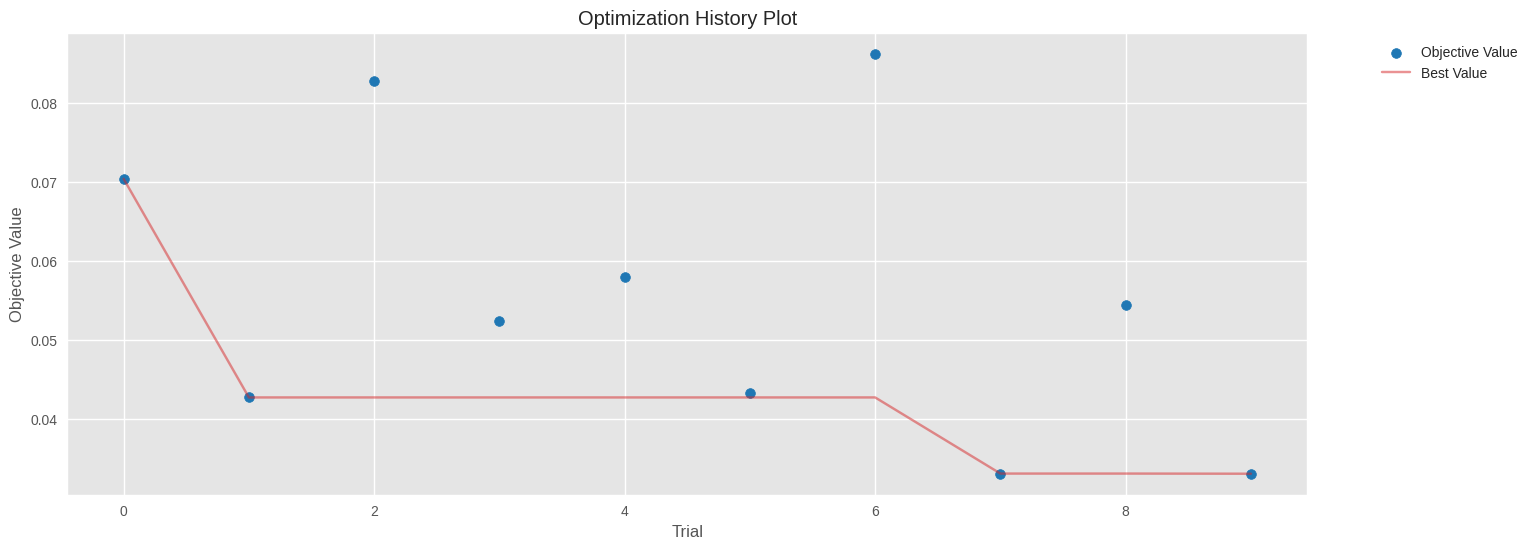

In [ ]:
plot_optimization_history(study);

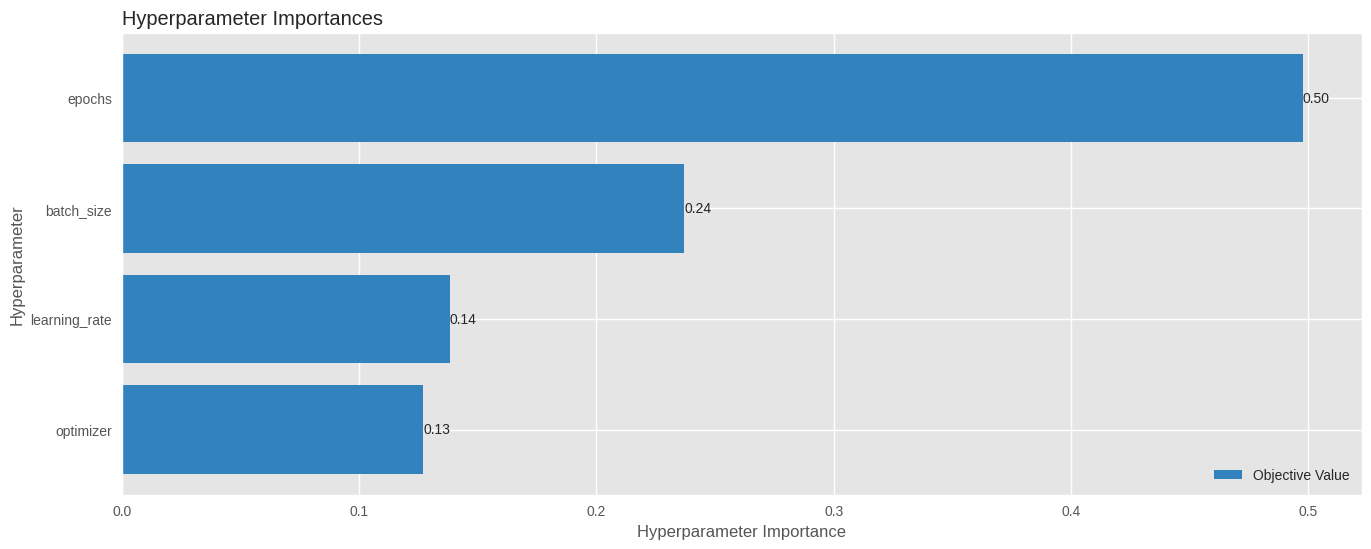

In [ ]:
plot_param_importances(study);

In [ ]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

In [ ]:
# Print all keys in the best_params dictionary
for key in best_params.keys():
    print(best_params.keys())

dict_keys(['optimizer', 'learning_rate', 'epochs', 'batch_size'])
dict_keys(['optimizer', 'learning_rate', 'epochs', 'batch_size'])
dict_keys(['optimizer', 'learning_rate', 'epochs', 'batch_size'])
dict_keys(['optimizer', 'learning_rate', 'epochs', 'batch_size'])


In [ ]:
# Define the LSTM model using the best hyperparameters
model = Sequential()

# Define default values or adjust as needed
lstm_units = 64
dropout_rate = 0.2

model = tf.keras.Sequential([
    LSTM(units=lstm_units, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(rate=dropout_rate),
    Dense(units=1)
])

# Compile the model using the best optimizer and learning rate from best_params
optimizer_val = list(best_params)[0]  # Retrieve the optimizer key from best_params

if optimizer_val == 'Adam':
    optimizer = optimizers.Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = optimizers.RMSprop(learning_rate=best_params['learning_rate'])

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


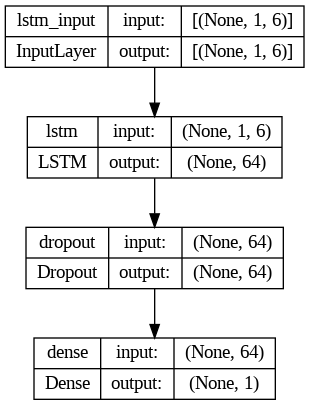

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 47.2 s, sys: 1.92 s, total: 49.2 s
Wall time: 1min 23s


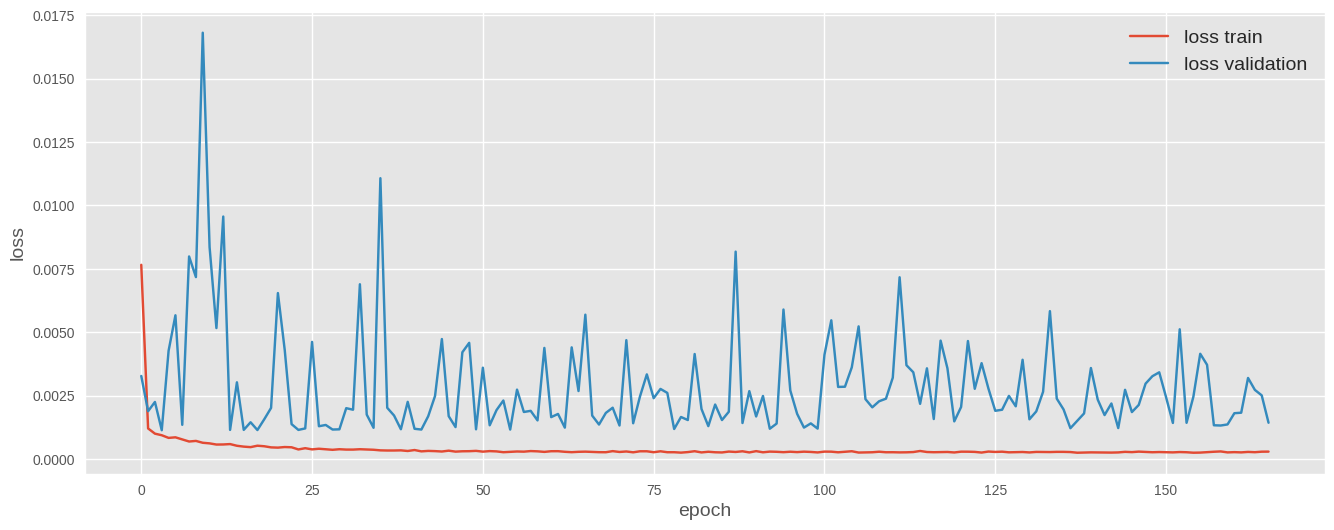

In [ ]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

3/3 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 0.0000e+00


[0.0015100162709131837, 0.0]

In [ ]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

3/3 [==============================] - 0s 3ms/step


In [ ]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(2506,) (65,)


In [ ]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [7.25654892 7.15095006 7.09776337 7.13589003 7.12234521]
Train Actual:  [8. 8. 8. 8. 7.]
Test Predicted:  [63.56618801 62.43933779 63.29913413 63.89336173 60.58856429]
Test Actual:  [63. 63. 64. 62. 60.]


In [ ]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.66 RMSE
Test Score: 2.44 RMSE


In [ ]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

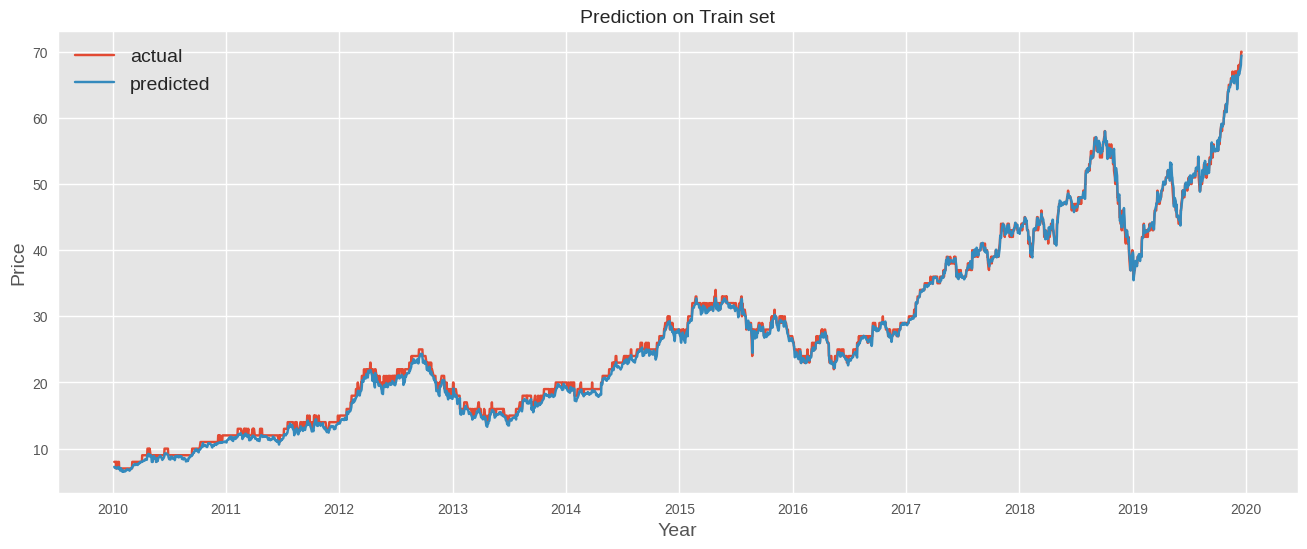

In [ ]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

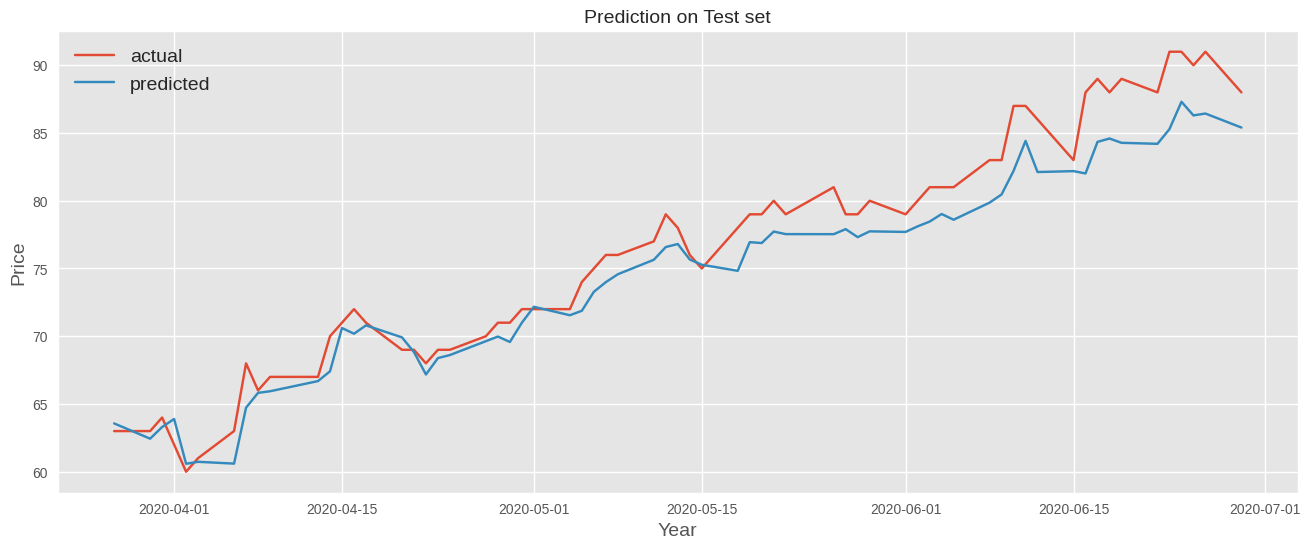

In [ ]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_test' contains actual values and 'yhat_test' contains predicted values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, yhat_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, yhat_test)

# Calculate R-squared (R2) score
r2 = r2_score(Y_test, yhat_test)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y_test - yhat_test) / Y_test)) * 100

# Display the Mean Absolute Percentage Error (MAPE)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 5.939129536926279
Root Mean Squared Error (RMSE): 2.437032937185355
Mean Absolute Error (MAE): 1.9581226996094472
R-squared (R2) Score: 0.9168213956339839
Mean Absolute Percentage Error (MAPE): 2.44%


In [ ]:
# Assuming 'Y_train' contains actual values and 'yhat_train' contains predicted values

# Calculate Mean Absolute Percentage Error (MAPE)
mape_train = np.mean(np.abs((Y_train - yhat_train) / Y_train)) * 100

# Display the Mean Absolute Percentage Error (MAPE) for the training set
print(f'Mean Absolute Percentage Error (MAPE) on Training set: {mape_train:.2f}%')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_train' contains the actual values and 'yhat_train' contains the predicted values for the training set

# Calculate Mean Squared Error (MSE) on the training set
mse_train = mean_squared_error(Y_train, yhat_train)

# Calculate Root Mean Squared Error (RMSE) on the training set
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Error (MAE) on the training set
mae_train = mean_absolute_error(Y_train, yhat_train)

# Calculate R-squared (R2) score on the training set
r2_train = r2_score(Y_train, yhat_train)

# Display the accuracy metrics for the training set
print(f'Mean Squared Error (MSE) on Training set: {mse_train:.2f}')
print(f'Root Mean Squared Error (RMSE) on Training set: {rmse_train:.2f}')
print(f'Mean Absolute Error (MAE) on Training set: {mae_train:.2f}')
print(f'R-squared (R2) Score on Training set: {r2_train:.2f}')

Mean Absolute Percentage Error (MAPE) on Training set: 2.64%
Mean Squared Error (MSE) on Training set: 0.44
Root Mean Squared Error (RMSE) on Training set: 0.66
Mean Absolute Error (MAE) on Training set: 0.54
R-squared (R2) Score on Training set: 1.00


In [ ]:
import numpy as np

def calculate_forecast_accuracy(yhat_test, Y_test):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_test - Y_test) / Y_test
    return accuracy

# Compute forecast accuracy for the test set
forecast_accuracy = calculate_forecast_accuracy(yhat_test, Y_test)

# Calculate the mean accuracy across all data points
mean_accuracy = np.mean(forecast_accuracy)

print(f'Mean Forecast Accuracy on Test Set: {mean_accuracy:.2f}')

Mean Forecast Accuracy on Test Set: 0.98


In [ ]:
def calculate_forecast_accuracy(yhat_train, Y_train):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_train - Y_train) / Y_train
    return accuracy

# Compute forecast accuracy for the training set
forecast_accuracy_train = calculate_forecast_accuracy(yhat_train, Y_train)

# Calculate the mean accuracy across all data points
mean_accuracy_train = np.mean(forecast_accuracy_train)

print(f'Mean Forecast Accuracy on Training Set: {mean_accuracy_train:.2f}')

Mean Forecast Accuracy on Training Set: 0.97
